<a href="https://colab.research.google.com/github/glasslion/kaggle-recognizing-faces-in-the-wild/blob/master/pytorch-vgg-face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
if not Path('/mnt/gdrive/My Drive/colab/kaggle.json').exists():
    from google.colab import drive
    drive.mount('/mnt/gdrive')
    !mkdir -p ~/.kaggle
    !cp '/mnt/gdrive/My Drive/colab/kaggle.json'  ~/.kaggle

In [0]:
if not Path('train.zip').exists():
    !kaggle competitions download -c recognizing-faces-in-the-wild

In [0]:
if not Path('train/F0002/MID1').exists():
    !unzip train.zip -d train
    !unzip test.zip -d test

In [0]:
import random
from pathlib import Path

from IPython.display import display
import pandas as pd
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


In [5]:
!ls train/F0002/MID1

P00009_face3.jpg  P00012_face2.jpg  P00015_face2.jpg  P00018_face1.jpg
P00010_face4.jpg  P00013_face2.jpg  P00016_face2.jpg
P00011_face1.jpg  P00014_face2.jpg  P00017_face3.jpg


In [6]:
train_dir = Path('train')
train_imgs = [str(img) for img in train_dir.glob('./**/*.jpg')]
len(train_imgs)

12379

## Extract Vgg Face Features

[official pretrained model](http://www.robots.ox.ac.uk/~albanie/pytorch-models.html)

In [0]:

import torch
import torch.nn as nn


class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_face_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [0]:
if not Path('models/vgg_face_dag.pth').exists():
    !mkdir models
    !wget http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth -P models
    !wget http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_m_face_bn_dag.pth -P models

In [0]:
model = vgg_face_dag('models/vgg_face_dag.pth')

In [0]:
device = torch.device('cuda')

In [0]:
model = model.to(device)

In [0]:
kin_samples = []
nonkin_samples = []

In [14]:
im = Image.open('train/F0670/MID1/P07004_face1.jpg')
im = np.array(im).astype(np.float32)
im = im.transpose((2,0,1))
assert im.shape == (3, 224, 224)

input_tensor = torch.from_numpy(im[None,:]).float().to(device)
out = model(input_tensor)
out.shape

torch.Size([1, 2622])

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class SimpleImageDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        im = Image.open(file)
        im = np.array(im).astype(np.float32)
        im = im.transpose((2,0,1))
        return torch.from_numpy(im).to(device)

In [0]:
dataset = SimpleImageDataset(train_imgs)

In [0]:
BATCH_SIZE=64
loader = DataLoader(
    dataset=dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)


In [0]:
def predict(model, loader):
    out_batches = []
    tq = tqdm(total=len(loader))
    for step, batch in enumerate(loader):
        with torch.no_grad():
            out = model(batch)
        out_batches.append(out.cpu().numpy())
        tq.update()
    return np.concatenate(out_batches)


In [37]:
train_feats = predict(model, loader)

In [0]:
np.save('train_feats.npy', train_feats)

## Kinship DEA

In [76]:
train_rel_df = pd.read_csv('train_relationships.csv')
df = train_rel_df
df['p1'] = 'train/'+ df['p1']
df['p2'] = 'train/' + df['p2']
df.head()

,p1,p2
0,train/F0002/MID1,train/F0002/MID3
1,train/F0002/MID2,train/F0002/MID3
2,train/F0005/MID1,train/F0005/MID2
3,train/F0005/MID3,train/F0005/MID2
4,train/F0009/MID1,train/F0009/MID4


In [0]:
def pick_img(dir):
    imgs = list(Path(dir).glob("*.jpg"))
    if len(imgs) == 0:
        return None
    path = random.choice(imgs)
    return str(path)

test_img = pick_img('train/F1000/MID7')
assert test_img.endswith('jpg')

In [0]:
def get_vggface_feats(img):
    idx = train_imgs.index(img)
    return train_feats[idx]
test_feats = get_vggface_feats('train/F1000/MID7/P10580_face1.jpg')
assert test_feats.shape == (2622,)

In [0]:
def cosine_similarity(a,b):
    dot = np.dot
    norm = np.linalg.norm
    return dot(a,b) /(norm(a)*norm(b))

def distance(x, y):
    return np.linalg.norm(x - y)


In [105]:
def diff_img(img1, img2):
    feats1 = get_vggface_feats(img1)
    feats2 = get_vggface_feats(img2)
    return cosine_similarity(feats1, feats2), distance(feats1, feats2)
diff_img('train/F1000/MID7/P10580_face1.jpg', 'train/F1000/MID7/P10580_face1.jpg')

(0.9999999, 0.0)

In [0]:
df['cosine_similarity'] = np.nan
df['distance'] = np.nan

for idx, row in df.iterrows():
    img1 = pick_img(row['p1'])
    img2 = pick_img(row['p2'])
    if img1 is None or img2 is None:
        continue
    cos, dis = diff_img(img1, img2)
    df.loc[idx, 'cosine_similarity'] = cos
    df.loc[idx, 'distance'] = dis

In [127]:
df.describe()

,distance,cosine_similarity
count,3362.000000,3362.000000
mean,242.517355,0.426708
std,48.959131,0.119016
min,111.407509,0.046784
25%,207.307251,0.342924
50%,241.722557,0.420967
75%,275.318512,0.512194
max,416.363434,0.749157


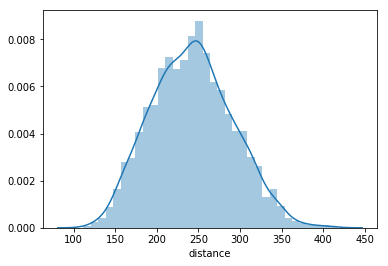

In [131]:
sns.distplot(df['distance'].dropna())


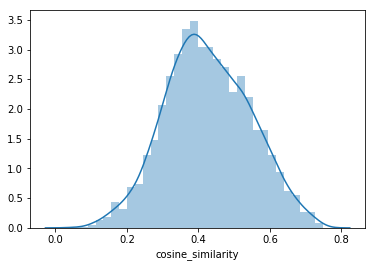

In [132]:
sns.distplot(df['cosine_similarity'].dropna())


In [150]:
df.shape

(3598, 4)

## Non-Kinship DEA

In [0]:
train_df = pd.DataFrame.from_dict({'file':train_imgs})

In [0]:
train_df['person'] = train_df['file'].str.rsplit('/', 1,expand=True)[0]

In [0]:
train_df['family'] = train_df['person'].str.rsplit('/', 1,expand=True)[0]

In [0]:
def sample_non_kin(df):
    res = []
    for i in range(5000):
        ia,ib = np.random.randint(0, len(train_df), size=2)
        sa = df.iloc[ia]
        sb = df.iloc[ib]
        if sa['family'] == sb['family']:
            continue
        res.append([sa['file'], sb['file']])
    return pd.DataFrame.from_records(res, columns=['i1', 'i2'])

    

In [0]:
df = sample_non_kin(train_df)

In [0]:
df['cosine_similarity'] = np.nan
df['distance'] = np.nan

for idx, row in df.iterrows():
    cos, dis = diff_img(row['i1'], row['i2'])
    df.loc[idx, 'cosine_similarity'] = cos
    df.loc[idx, 'distance'] = dis

In [185]:
df.describe()

,cosine_similarity,distance
count,4976.000000,4976.000000
mean,0.362073,262.145389
std,0.106658,45.709286
min,-0.056893,124.562523
25%,0.289158,230.951817
50%,0.362638,260.787643
75%,0.434240,291.690849
max,0.710273,454.388336


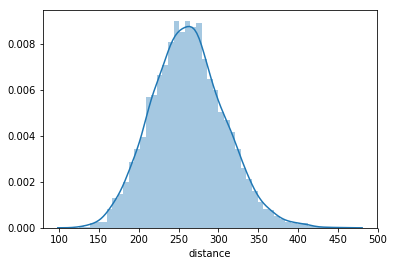

In [187]:
sns.distplot(df['distance'].dropna())

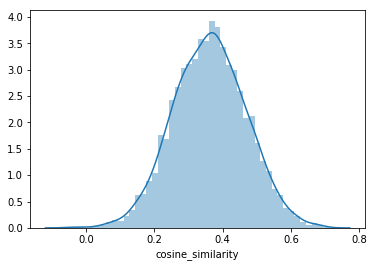

In [188]:
sns.distplot(df['cosine_similarity'].dropna())